In [13]:
# Initial Imports
import numpy as np
import pandas as pd

In [14]:
# Set random seed for reproducibility
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [15]:
# Load the fear and greed sentiment data from bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [16]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [17]:
# Join the data into a single Dataframe
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [18]:
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [27]:
# This function accepts the column number for the features (X) and the target (y)
def window_data(df, window, feature_col_number, target_col_number):
  X = []
  y = []
  for i in range(len(df) - window -1):
    features = df.iloc[i:(i + window), feature_col_number]
    target = df.iloc[(i + window), target_col_number]
    X.append(features)
    y.append(target)
  return np.array(X), np.array(y).reshape(-1, 1)


In [50]:
# Predict closing prices using 10 day window
window_size = 1

# Column index 0 is 'fng_value'
# Column index 1 is 'Close' column
feature_column = 0
target_column = 1

In [51]:
X, y = window_data(df, window_size, feature_column, target_column)

In [52]:
# Use 70% of data for training and the remaining for testing
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [53]:
from sklearn.preprocessing import MinMaxScaler
# Use scaler to scale data 0 and 1
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit scaler to training data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scaler the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit scaler for testing data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

In [54]:
# Reshape the features model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [56]:
# Build the LSTM model
model = Sequential()

# Initial setup
number_of_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_of_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_of_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_of_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [57]:
# Compile model
model.compile(optimizer="adam", loss="mean_squared_error")

In [58]:
# Summarize the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 1, 5)              140       
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 5)              0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 1, 5)              220       
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 5)              0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 5)                 220       
_________________________________________________________________
dropout_8 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [59]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
378/378 [==============================] - 5s 4ms/step - loss: 0.1206
Epoch 2/10
378/378 [==============================] - 1s 4ms/step - loss: 0.0571
Epoch 3/10
378/378 [==============================] - 1s 4ms/step - loss: 0.0565
Epoch 4/10
378/378 [==============================] - 2s 4ms/step - loss: 0.0520
Epoch 5/10
378/378 [==============================] - 1s 4ms/step - loss: 0.0531
Epoch 6/10
378/378 [==============================] - 1s 4ms/step - loss: 0.0498
Epoch 7/10
378/378 [==============================] - 1s 4ms/step - loss: 0.0467
Epoch 8/10
378/378 [==============================] - 1s 4ms/step - loss: 0.0445
Epoch 9/10
378/378 [==============================] - 1s 4ms/step - loss: 0.0446
Epoch 10/10
378/378 [==============================] - 1s 4ms/step - loss: 0.0463


In [60]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=1)

6/6 [==============================] - 1s 3ms/step - loss: 0.0969


0.09685755521059036

In [61]:
# Make predictions
predictions = model.predict(X_test)

In [62]:
# Recover original prices instead of scaled
predicted_prices = y_test_scaler.inverse_transform(predictions)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [63]:
# Create dataframe of real and predicted values
equities = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ])
equities.tail

,Real,Predicted
2019-07-25,9772.139648,5184.783203
2019-07-26,9882.429688,4800.444824
2019-07-27,9847.450195,5232.705566
2019-07-28,9478.320313,4863.935059
2019-07-29,9531.769531,5360.020020


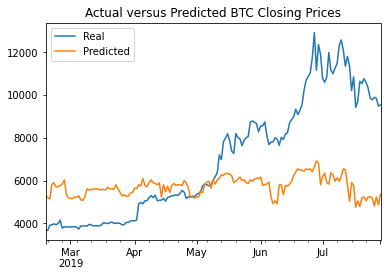

In [64]:
# Plot real versus predicted values on to a line chart
equities.plot(title="Actual versus Predicted BTC Closing Prices")

1. The model with the lower loss is the closing price model. 

2. The model which tracked the actual values versus predicted values best over time is the closing price model. 

3. A window size of 1 seems like the appropriate window size, as it seems to track day-to-day volatility more accurately. 
